In [1]:
import pandas as pd
import numpy as np
import datetime
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import string
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df_e = pd.read_csv('PJME_hourly.csv')
df_w = pd.read_csv('PJMW_hourly.csv')

**PJM Hourly Energy Consumption Data**

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

**Modelling Techniques:**

**Statistical models:**

- Ignore the time-series aspect completely and model using traditional statistical modeling toolbox. 

    *Examples: Regression-based models (prophet from facebook)*
    
    
- Univariate statistical time-series modeling.

    *Examples: Averaging and smoothing models, ARIMA models.*

**Machine learning models:**

- Ignore the time-series aspect completely and model using traditional machine learning modeling toolbox.
       *Examples. Support Vector Machines (SVMs), Random Forest Regression, Gradient-Boosted Decision Trees (GBDTs).*

- Recurrent neural networks (RNNs)

For this project we are going to focus on the scope on comparing the forecasting performances of these two types of modelling techniques with further recommendations for the dataset. We are not going to include external data information.

we make the datetime the index colum to join the dataframes later

## TimeSeries preprocessing

We make sure our data is a univariate time series to prepare it for EDA and future analysis.

In [3]:
df_e.shape

(145366, 2)

In [4]:
df_e['Datetime'] =  pd.to_datetime(df_e['Datetime'])
df_w['Datetime'] =  pd.to_datetime(df_w['Datetime'])


In [5]:
df =  pd.merge(df_e, df_w,  how = 'left', on= 'Datetime') #

In [6]:
df.head()

,Datetime,PJME_MW,PJMW_MW
0,2002-12-31 01:00:00,26498.0,5077.0
1,2002-12-31 02:00:00,25147.0,4939.0
2,2002-12-31 03:00:00,24574.0,4885.0
3,2002-12-31 04:00:00,24393.0,4857.0
4,2002-12-31 05:00:00,24860.0,4930.0


In [7]:
df['PJMW_MW'] = df['PJMW_MW'].interpolate(method='linear', axis=0).ffill()

In [8]:
df['Energy'] = df['PJME_MW'] + df['PJMW_MW']
df_ = df.copy()
df = df.drop(['PJME_MW','PJMW_MW'], axis = 1)

In [9]:
df.set_index('Datetime', inplace = True) #make the index is out date time

In [10]:
df.head().append(df.tail())

,Energy
Datetime,
2002-12-31 01:00:00,31575.0
2002-12-31 02:00:00,30086.0
2002-12-31 03:00:00,29459.0
2002-12-31 04:00:00,29250.0
2002-12-31 05:00:00,29790.0
2018-01-01 20:00:00,52685.0
2018-01-01 21:00:00,52124.0
2018-01-01 22:00:00,50640.0
2018-01-01 23:00:00,48122.0


# Plotting the data

Now that we made sure our timeseries has no NaN values (interpolation with forward fill to avoid lookout) and its in the correct format, we proceed to visualize it.

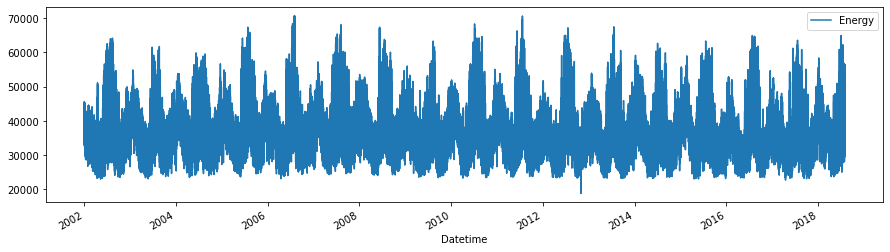

In [11]:
# Plot time series data
df.plot(y=["Energy"], figsize=(15,4))

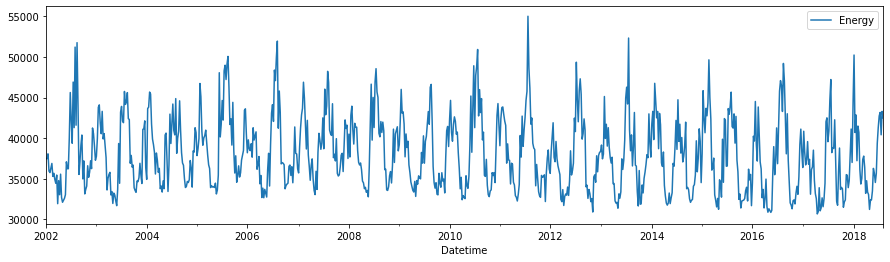

In [12]:
df[["Energy"]].resample("1w").median().plot(figsize=(15,4))

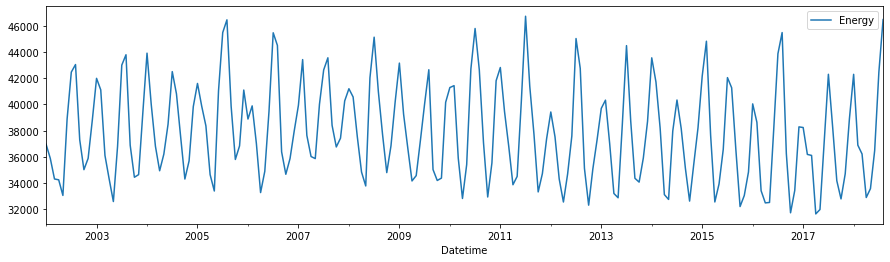

In [13]:
df[["Energy"]].resample("1m").median().plot(figsize=(15,4))

Here we see 3 plots of the same timeserie of the Energy consumption (East and West) resampled in minutes, weeks and months. This was made to see variance and first signs of stationarity.

the .resample() method has given us a lower cadence dataset without all the noise. We still can see there are high spikes in energy consumption over some weeks.

Similar to this method is the rolling window calculations, which return the same cadence of data but performed over a rolling window of a given width. We can summon this calculation using the .rolling() method.

We can see that our data doesnt follow any trend and is hard to appreciate its stationarity.

Stationarity is a statistical assumption that a time-series has:

1. Constant mean
2. Constant variance
3. Autocovariance does not depend on time

If we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past. This general statement holds for most training data and modeling tasks.

We extracted a script of code from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ to analyze stationarity of our dataset performing an augmented dickey-fuller test. This test asumes the hypothesis that our data is stationary and we have to prove its not.

In [14]:
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

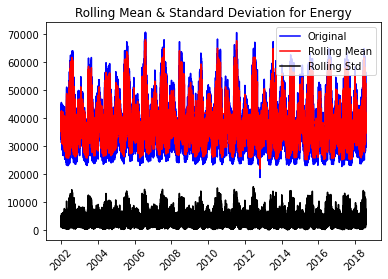

Results of Dickey-Fuller Test:
Test Statistic                    -19.098022
p-value                             0.000000
# Lags Used                        74.000000
Number of Observations Used    145299.000000
Critical Value (1%)                -3.430395
Critical Value (5%)                -2.861560
Critical Value (10%)               -2.566781
dtype: float64


In [15]:
test_stationarity(df = df, ts = 'Energy')

We failed the reject the hypothesis of the Augmented Dickey fuller test so we confirm that the Energy consumption is stationary with more than 99% certainty.

# Modelling with prophet

Timeseries modelling can take two approaches, leveraging the timeserie aspect of the data using statistical model such as ARIMA (where past data affects future data) or take an approach of linear regression where we forget about the time dependency nature and try to fit the best curve to the dataset.

Facebook developed this tool (https://facebook.github.io/prophet/) to make the forecasting problem simpler to the daily analyst without having to do heavy researvh on statistichal modelling techniques such as Autoregressive models or more sophisticated ones such as ARIMA.

This tool  allows forecatsing using additive or component models relatively easily. It can also include things like:

- Day of week effects
- Day of year effects
- Holiday effects
- Trend trajectory
- Can do MCMC sampling

In [16]:
!pip install pystan
!pip install fbprophet
from fbprophet import Prophet
import datetime
from datetime import datetime

I first have to create my training set and my testing set. I will train the models on prior data to last year, which will be forecasted

In [17]:
split_date = '2017-01-01'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

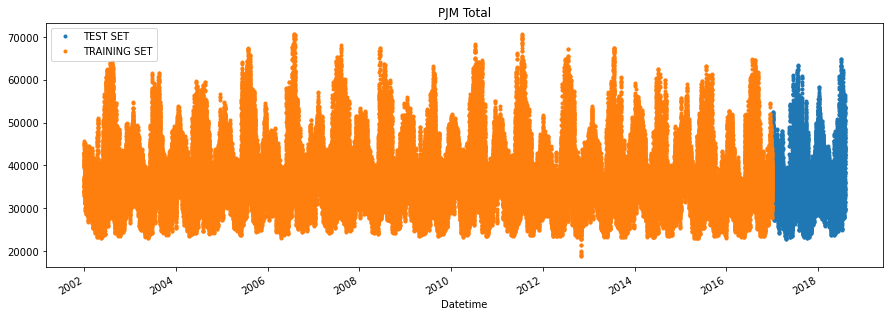

In [18]:
# Plot train and test so you can see where we have split
df_test \
    .rename(columns={'Energy': 'TEST SET'}) \
    .join(df_train.rename(columns={'Energy': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM Total', style='.')
plt.show()

Prophet expects a dataframe where the Dates are named 'ds' and the target value (in this case, Energy) is named 'y' so we rename the columns of our dataset.

In [19]:
# get relevant data - note: could also try this with ts_log_diff
df_prophet = df[['Energy']] # can try with ts_log_diff

# reset index
df_prophet = df_prophet.reset_index()

# rename columns
df_prophet = df_prophet.rename(columns = {'Datetime': 'ds', 'Energy': 'y'}) # can try with ts_log_diff, this names are set to be named like this

# Change 'ds' type from datetime to date (necessary for FB Prophet)
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Change 'y' type to numeric (necessary for FB Prophet)
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='ignore')


Whats good about forecasting with prophet (if youre a python user familiar with sklearn) is that they followed a similar synthax when it comed to choose the model and fit the data.

In [20]:
model = Prophet(growth = 'linear',daily_seasonality = True)
model.fit(df_prophet)

In [21]:
# Predict on training set with model
df_test_fcst = model.predict(df=df_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
#we could have also used the function:
#future = m.make_future_dataframe(period = 365), this would have forecasted 1 year into the future

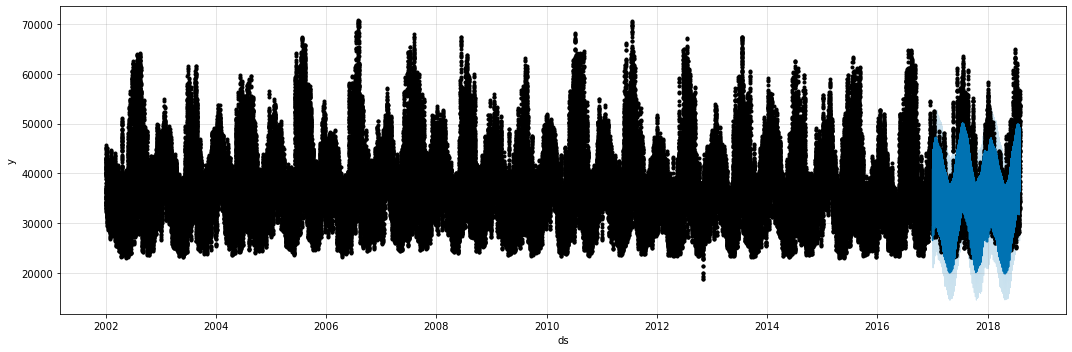

In [22]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_test_fcst,
                 ax=ax)
plt.show()

In blue we can see the prophet forecast for the year 2017 going into 2018 (our testing dataset). One of the many advantages of forecasting with prophet is that it can decompose the forecast into:

- trend
- yearly
- weekly
- daily

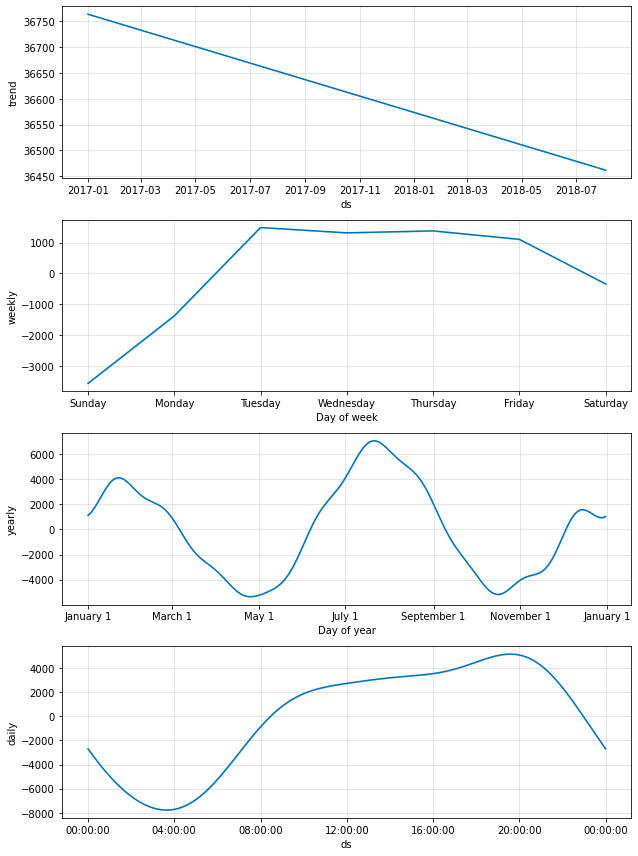

In [23]:
# Plot the components of the model
fig = model.plot_components(df_test_fcst)

Here we can see some interesting trends when it comes to the data, and the data starts to reveal itself. We can see a peak energy consumption from Tuesday to Friday, decreasing a little bit on Saturday. 

The yearly trend is clear, being end of July and August peak energy consumption by the grid.

Daily data reveals a starting point in energy past 4:00 AM going into a peak energy consumption by 20:00.

Now we are going to calculate the accuracy of the model forecasted.

In [24]:
df_test_fcst.head().append(df_test.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Energy
0,2017-01-01 01:00:00,36763.343426,24081.627641,34459.047606,36763.343426,36763.343426,-7455.942306,-7455.942306,-7455.942306,-4955.938302,...,-3621.424206,-3621.424206,1121.420202,1121.420202,1121.420202,0.0,0.0,0.0,29307.401120,NaN
1,2017-01-01 02:00:00,36763.321744,22472.081050,32944.804352,36763.321744,36763.321744,-9157.132155,-9157.132155,-9157.132155,-6625.349522,...,-3656.923586,-3656.923586,1125.140952,1125.140952,1125.140952,0.0,0.0,0.0,27606.189589,NaN
2,2017-01-01 03:00:00,36763.300062,21087.159131,32421.767319,36763.300062,36763.300062,-10130.116047,-10130.116047,-10130.116047,-7580.159253,...,-3678.855694,-3678.855694,1128.898900,1128.898900,1128.898900,0.0,0.0,0.0,26633.184015,NaN
3,2017-01-01 04:00:00,36763.278379,21383.089817,32156.304563,36763.278379,36763.278379,-10259.171771,-10259.171771,-10259.171771,-7704.891957,...,-3686.973809,-3686.973809,1132.693995,1132.693995,1132.693995,0.0,0.0,0.0,26504.106608,NaN
4,2017-01-01 05:00:00,36763.256697,21871.671840,32747.714508,36763.256697,36763.256697,-9448.550597,-9448.550597,-9448.550597,-6903.950727,...,-3681.126055,-3681.126055,1136.526186,1136.526186,1136.526186,0.0,0.0,0.0,27314.706100,NaN
2018-01-01 20:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52685.0
2018-01-01 21:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52124.0
2018-01-01 22:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50640.0
2018-01-01 23:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48122.0
2018-01-02 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46299.0


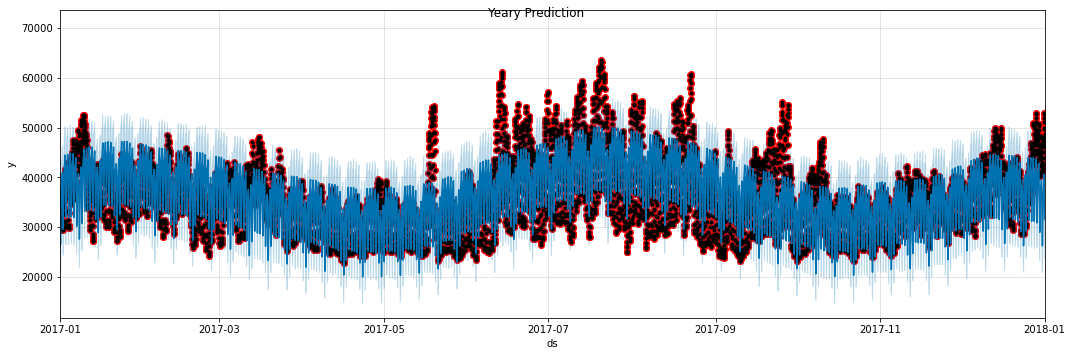

In [25]:
import datetime
# Plot Yearly forecasts
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['Energy'], color='r')
ax.set_xlim([datetime.datetime(2017, 1, 1), datetime.datetime(2018, 1, 1)])
fig = model.plot(df_test_fcst, ax=ax)
plot = plt.suptitle('Yeary Prediction')




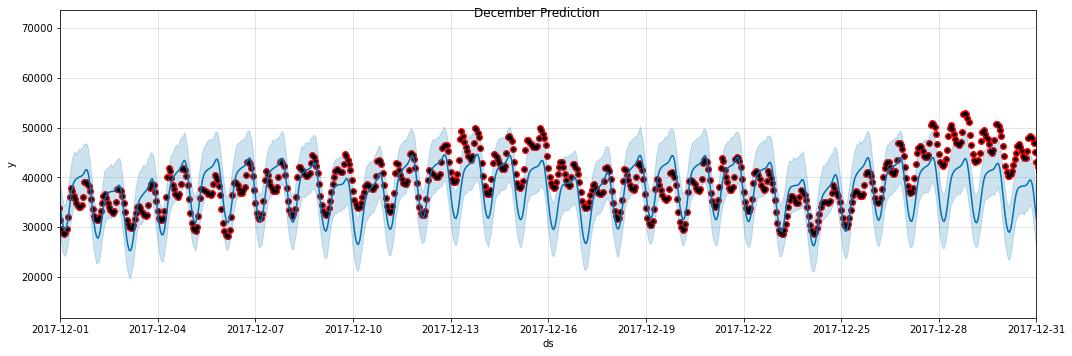

In [26]:
# Plot monthly forecasts (last month)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['Energy'], color='r')
ax.set_xlim([datetime.date(2017, 12, 1), datetime.date(2017, 12, 31)])
fig = model.plot(df_test_fcst, ax=ax)
plot = plt.suptitle('December Prediction')



We can appreciate the errors made when we disect and visualize December 2017 energy consumption forecast.

### Error measuring

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:

MSE = mean_squared_error(y_true=df_test['Energy'],
                   y_pred=df_test_fcst['yhat'])

MAE = mean_absolute_error(y_true=df_test['Energy'],
                   y_pred=df_test_fcst['yhat'])

MAPE = mean_absolute_percentage_error(y_true=df_test['Energy'],
                   y_pred=df_test_fcst['yhat'])

print('MSE:'+' '+ str(MSE))
print('MAE:' +' '+str(MAE))
print('MAPE:' +' '+ str(MAPE) + '%')

MSE: 47662078.87396657
MAE: 5427.798461809481
MAPE: 15.134721165600896%


We now save the dataframe into a csv file to work it with another forecasting model

In [29]:
df.to_csv('Energy_PJM.csv',index=True)
df_test_fcst.to_csv('Prophet_Forecast.csv', index = True)